# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        word_id = self.word2id[word]
        return self.embeddings[word_id]
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        # Step 1: get embedding
        v1 = self.encode(word1)
        v2 = self.encode(word2)
        # Step 2: return cosine of embeddings
        norm_prod = np.linalg.norm(v1) * np.linalg.norm(v2)
        return np.dot(v1, v2) / norm_prod
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort
        
        # Step 1: compute all scores
        scores = [self.score(word, w_) for w_ in self.words]
        # Step 2: sort scores, get idx of 5 highest ones
        best_k_idx = np.flip(np.argsort(scores))[:k]
        return [self.id2word[idx] for idx in best_k_idx]

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.2644975466165475
cat dog 0.7078641298542562
cat pet 0.6753313359976381
Paris France 0.6892958925806542
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348005
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'pup', 'canine']
['dogs', 'dog', 'cats', 'puppies', 'Dogs']
['Paris', 'France', 'Parisian', 'Marseille', 'Brussels']
['Germany', 'Austria', 'Europe', 'Berlin', 'Hamburg']


In [5]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # IDF of word: log(num_docs/(num of docs containing word))
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        num_docs = len(sentences)
        dcount = defaultdict(int)
        for sent in sentences:
            dseen = defaultdict(bool)  # whether word was already seen in current sentence
            for word in sent.split():
                # if word wasn't seen, count it and flag it
                if not(dseen[word]):
                    dseen[word] = True  # set to True
                    dcount[word] += 1
        idf = defaultdict(float)
        for word, c in dcount.items():
            idf[word] = np.log(num_docs/c)
        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        sentence_filtered = []
        for w in sentence.split():
            if w in self.word2vec.word2id:
                sentence_filtered.append(w)
        if idf is None:
            res = np.mean([
                self.word2vec.encode(word)
                for word in sentence_filtered
            ], axis=0)
            return res
        else:
            res = np.mean([
                self.word2vec.encode(word) * idf[word]
                for word in sentence_filtered
            ], axis=0)
            return res

    def score(self, sentence1, sentence2, idf=None):
        v1 = self.encode(sentence1, idf=idf)
        v2 = self.encode(sentence2, idf=idf)
        norm_prod = np.linalg.norm(v1) * np.linalg.norm(v2)
        return np.dot(v1, v2) / norm_prod
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)  # shape (embed_dim,)
        keys = np.vstack([self.encode(sent, idf) for sent in sentences])
        # keys is of shape (n_sentences,embed_dim)
        
        norm_query = np.linalg.norm(query, keepdims=True)
        norm_keys = np.linalg.norm(keys, axis=1)  # shape (n_sent,1)
        norm_prod = norm_query * norm_keys  # shape (n_sent,)
        scores = keys @ query
        scores /= norm_prod  # shape (n_sent,)
        best_k = np.flip(np.argsort(scores))[:k]
        
        return [sentences[idx] for idx in best_k]

In [6]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251476
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) a small boy following 4 geese . 
5) 2 female babies eating chips . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6400799939346383
2 female babies eating chips . 
1) 2 female babies eating chips . 
2) 2 kids holding hands and smiling . 
3) 2 chinese people wearing traditional clothes 
4) five children , 3 boys and 2 girls playing soccer in a grass field . 
5) 3 couples in white clothes are playing piggyback . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        
        self.common_words = []
        
        # Loop over english words
        for w in self.en_word2vec.words:
            wid = self.fr_word2vec.word2id.get(w)  # None if not other vocab
            if wid is not None:
                self.common_words.append(w)
        
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        # assert X.shape[0] == 300 and Y.shape[0] == 300
        vocab_size = len(self.fr_word2vec.words)
        common_vocab_size = len(self.common_words)
        X = np.zeros((300, common_vocab_size))
        Y = np.zeros((300, common_vocab_size))
        for i, w in enumerate(self.common_words):
            X[:, i] = self.fr_word2vec.encode(w)
            Y[:, i] = self.en_word2vec.encode(w)
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings @ W.transpose() is in the same space as en_word2vec.embeddings
        U, _, V_t = np.linalg.svd(Y @ X.T)
        W = U @ V_t
        assert W.shape == (300, 300)
        
        self.W = W  # inverse is W.T
        
        # push the FR embeddings to the shared space
        ## shape (vocab_size, embed_dim)
        return (W @ self.fr_word2vec.embeddings.T).T
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        fr_query = self.fr_word2vec.encode(fr_word)  # shape (embed_dim,)
        aligned_query = self.W @ fr_query  # shape (embed_dim,), in English-space
        # Aligned English vocabulary
        en_embeds = self.en_word2vec.embeddings  # shape (vocab, embed_dim)
        
        # dist = np.linalg.norm(aligned_query - aligned_embeds, axis=1)  # shape vocab_size
        # best_k = np.argsort(dist)[:k]
        # print("best k:", best_k, "| scores:", dist[best_k])
        
        norm_prod = np.linalg.norm(aligned_query)*np.linalg.norm(en_embeds, axis=1)
        scores = en_embeds @ aligned_query / norm_prod
        best_k = np.flip(np.argsort(scores))[:k]
        
        return [self.en_word2vec.words[idx] for idx in best_k]

In [8]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [9]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

def process_line(line):
    try:
        sentiment = int(line[0])
    except ValueError:
        print(line)
        print("errored on", line[0])
        return
    sent = line[1:]
    return [sentiment, sent]

with open(train_filepath, 'r') as f:
    sentiment_train, sentences_train = zip(*[process_line(line.strip('\n')) for line in f])
    sentences_train = list(sentences_train)
    sentiment_train = np.asarray(sentiment_train)
with open(dev_filepath, 'r') as f:
    sentiment_dev, sentences_dev = zip(*[process_line(line.strip('\n')) for line in f])
    sentences_dev = list(sentences_dev)
    sentiment_dev = np.asarray(sentiment_dev)
with open(test_filepath, 'r') as f:
    ## No processing to do here
    sentences_test = [line.strip('\n') for line in f]

In [10]:
# 2 - Encode sentences with the BoV model above

word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

data_embed_train = np.vstack([
    sentence2vec.encode(sent, idf=idf) for sent in sentences_train
])

data_embed_dev = np.vstack([
    sentence2vec.encode(sent, idf=idf) for sent in sentences_dev
])

data_embed_test = np.vstack([
    sentence2vec.encode(sent, idf=idf) for sent in sentences_test
])

# Normalize data
from sklearn.preprocessing import scale

data_embed_train = scale(data_embed_train, axis=0)
data_embed_dev = scale(data_embed_dev, axis=0)
data_embed_test = scale(data_embed_test, axis=0)

Loaded 50000 pretrained word vectors


In [11]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

params = {
    'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]
}

param_list = model_selection.ParameterGrid(params)

results_ = []
regressors_ = []

for p in param_list:
    regressor = LogisticRegression(solver='liblinear', **p)
    print(p)
    regressor.fit(data_embed_train, sentiment_train)
    trscore = regressor.score(data_embed_train, sentiment_train)
    devscore = regressor.score(data_embed_dev, sentiment_dev)
    print("Train score:", trscore, end='. ')
    print("Dev score:", devscore)
    regressors_.append(regressor)
    results_.append({
        'C': p['C'],
        'train': trscore,
        'dev': devscore
    })

results_ = np.array([
    [d['C'], d['train'], d['dev']]
    for d in results_
])

{'C': 0.01}
Train score: 0.4477996254681648. Dev score: 0.38419618528610355
{'C': 0.02}
Train score: 0.4521301498127341. Dev score: 0.3869209809264305
{'C': 0.05}
Train score: 0.45283239700374533. Dev score: 0.3814713896457766
{'C': 0.1}
Train score: 0.45493913857677903. Dev score: 0.3796548592188919
{'C': 0.2}
Train score: 0.455875468164794. Dev score: 0.3823796548592189
{'C': 0.3}
Train score: 0.4562265917602996. Dev score: 0.3796548592188919
{'C': 0.5}
Train score: 0.45692883895131087. Dev score: 0.38056312443233425


In [12]:
best_CV = np.max(results_[:, 2])  # get best CV value
# filter on being best CV
result_best_CV = results_[results_[:,2] == best_CV]
# get C with matching best CV and best train score
best_C = result_best_CV[np.argmax(result_best_CV[:,1]), 0]
print("best C:", best_C)
best_idx = np.argwhere(results_[:,0] == best_C)[0,0]
print(best_idx)

regressor_best = regressors_[best_idx]

# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

test_predict_ = regressor_best.predict(data_embed_test)
print(test_predict_)

with open("logreg_bow_y_test_sst.txt", 'w') as f:
    for p in test_predict_:
        f.write(str(p) + '\n')

best C: 0.02
1
[1 3 2 ... 3 3 0]


In [13]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

model = MLPClassifier(random_state=10,
                      hidden_layer_sizes=(128,),
                      alpha=1e-1, early_stopping=True)

model.fit(data_embed_train, sentiment_train)

train_score = np.mean(model.predict(data_embed_train) == sentiment_train)
print("Train score:", train_score)
dev_score = np.mean(model.predict(data_embed_dev) == sentiment_dev)
print("Dev score:", dev_score)

test_predict_ = regressor_best.predict(data_embed_test)
print(test_predict_)

with open("percept_bow_y_test_sst.txt", 'w') as f:
    for p in test_predict_:
        f.write(str(p) + '\n')

Train score: 0.5683520599250936
Dev score: 0.3760217983651226
[1 3 2 ... 3 3 0]


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [14]:
import tensorflow as tf

In [15]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/
from tensorflow.keras.preprocessing import text

In [16]:
vocab_size = 50000  # size of the vocabulary
sequence_train = [text.one_hot(sent, vocab_size) for sent in sentences_train]
sequence_dev = [text.one_hot(sent, vocab_size) for sent in sentences_dev]
sequence_test = [text.one_hot(sent, vocab_size) for sent in sentences_test]

In [62]:
sequence_train[4].shape

(49,)

In [60]:
sequence_dev[4].shape

(44,)

In [55]:
sequence_test[1].shape

(52,)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [17]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
sequence_train = pad_sequences(sequence_train)
sequence_dev = pad_sequences(sequence_dev)
sequence_test = pad_sequences(sequence_test)

In [19]:
y_train = tf.one_hot(sentiment_train, 5).numpy()
y_dev = tf.one_hot(sentiment_dev, 5).numpy()

## 4.2 - Design and train your model

In [79]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.

# ADAPT CODE BELOW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 24  # word embedding dimension
nhid       = 32 # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size+1, embed_dim, mask_zero=True))
model.add(LSTM(nhid, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(n_classes, activation='softmax'))

In [80]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 24)          1200024   
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                7296      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 1,207,485
Trainable params: 1,207,485
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 128
n_epochs = 10

history = model.fit(sequence_train, y_train,
                    batch_size=bs, nb_epoch=n_epochs,
                    validation_data=(sequence_dev, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 5s 558us/sample - loss: 1.5792 - accuracy: 0.2736 - val_loss: 1.5671 - val_accuracy: 0.2816
Epoch 2/10
8544/8544 [==============================] - 3s 367us/sample - loss: 1.5326 - accuracy: 0.3454 - val_loss: 1.4907 - val_accuracy: 0.3579
Epoch 3/10
8544/8544 [==============================] - 3s 331us/sample - loss: 1.3698 - accuracy: 0.4243 - val_loss: 1.3926 - val_accuracy: 0.3797
Epoch 4/10
8544/8544 [==============================] - 3s 317us/sample - loss: 1.1804 - accuracy: 0.5005 - val_loss: 1.3874 - val_accuracy: 0.3960
Epoch 5/10
8544/8544 [==============================] - 3s 318us/sample - loss: 1.0192 - accuracy: 0.5781 - val_loss: 1.4169 - val_accuracy: 0.3924
Epoch 6/10
8544/8544 [==============================] - 3s 319us/sample - loss: 0.8812 - accuracy: 0.6406 - val_loss: 1.4863 - val_accuracy: 0.3769
Epoch 7/10
8544/8544 [==============================] - 3s 321us

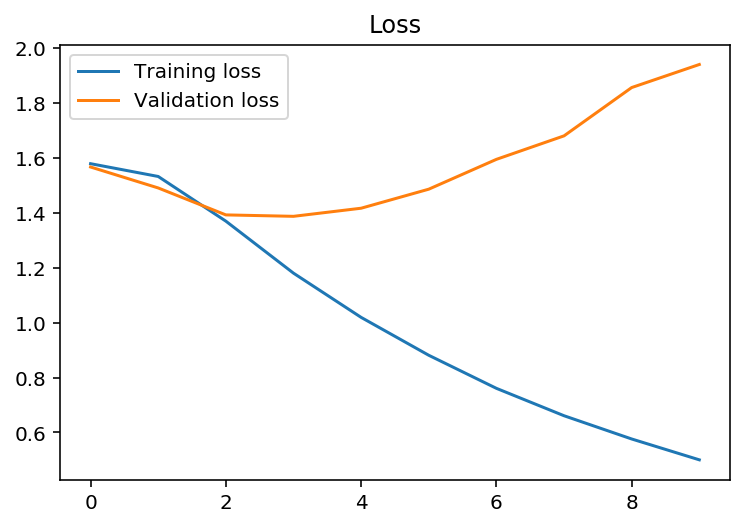

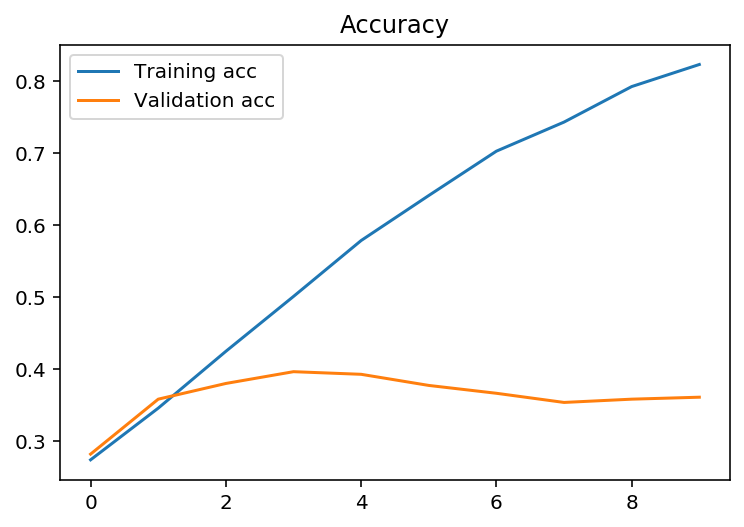

In [82]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Loss")

fig.savefig('images/loss.png')

fig = plt.figure()
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Accuracy");

fig.savefig('images/accuracy.png')

In [83]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

y_test_predict = model.predict(sequence_test)

In [84]:
y_test_predict_argmax = [np.argmax(y) for y in y_test_predict]

In [85]:
with open("logreg_lstm_y_test_sst.txt", "w") as f:
    f.writelines([str(y)+'\n' for y in y_test_predict_argmax])

## 4.3 - innovate !

In [ ]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

In [186]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

In [187]:
embed_dim  = 32  # word embedding dimension
nhid       = 32 # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size+1, embed_dim, mask_zero=True))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(nhid))
model.add(Dropout(.3))
model.add(Dense(n_classes, activation='softmax'))

In [188]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  optimizers.Adam(learning_rate=2e-4) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, None, 32)          1600032   
_________________________________________________________________
conv1d_48 (Conv1D)           (None, None, 64)          6208      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, None, 64)          12352     
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 5)               

In [189]:
# ADAPT CODE BELOW
bs = 128
n_epochs = 10

history = model.fit(sequence_train, y_train,
                    batch_size=bs, nb_epoch=n_epochs,
                    validation_data=(sequence_dev, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 2s 198us/sample - loss: 1.5838 - accuracy: 0.2670 - val_loss: 1.5715 - val_accuracy: 0.2870
Epoch 2/10
8544/8544 [==============================] - 1s 115us/sample - loss: 1.5671 - accuracy: 0.2809 - val_loss: 1.5710 - val_accuracy: 0.2543
Epoch 3/10
8544/8544 [==============================] - 1s 115us/sample - loss: 1.5609 - accuracy: 0.2904 - val_loss: 1.5687 - val_accuracy: 0.2843
Epoch 4/10
8544/8544 [==============================] - 1s 116us/sample - loss: 1.5524 - accuracy: 0.3131 - val_loss: 1.5643 - val_accuracy: 0.3097
Epoch 5/10
8544/8544 [==============================] - 1s 119us/sample - loss: 1.5365 - accuracy: 0.3453 - val_loss: 1.5522 - val_accuracy: 0.3342
Epoch 6/10
8544/8544 [==============================] - 1s 120us/sample - loss: 1.5051 - accuracy: 0.3853 - val_loss: 1.5214 - val_accuracy: 0.3306
Epoch 7/10
8544/8544 [==============================] - 1s 145us

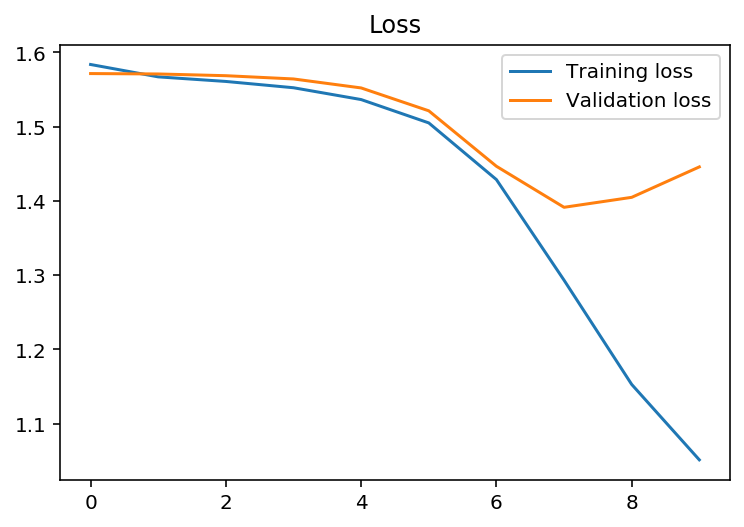

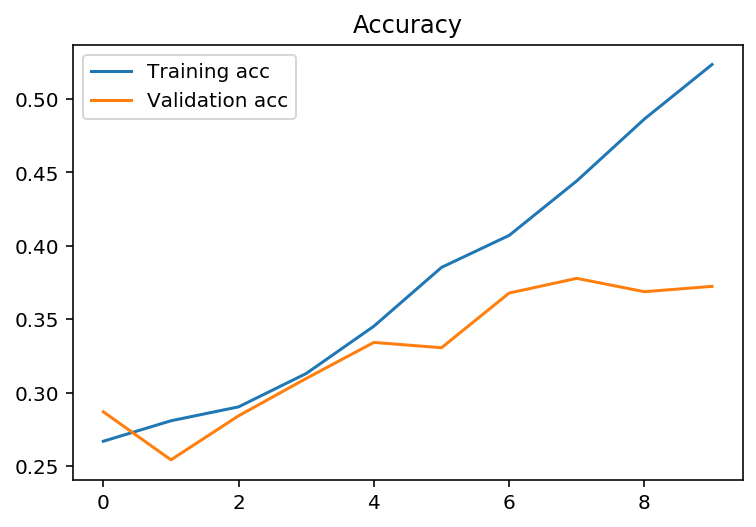

In [190]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Loss")

fig.savefig('images/loss.png')

fig = plt.figure()
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Accuracy");

fig.savefig('images/accuracy.png')

In [191]:
test_predict_ = model.predict(sequence_test)

with open("softmax_cnn_y_test_sst.txt", 'w') as f:
    for p in test_predict_:
        f.write(str(p) + '\n')